In [34]:
%matplotlib inline
import networkx as nx
from collections import defaultdict

## Acceptor



In [17]:
START = '$'

def find_next_state(G, current_state, symbol):
    for _, node, edge_attr in G.out_edges(current_state, data=True):
        if edge_attr.get('read') == symbol:
            return node

def accepts(G, input_seq):
    state = START
    for next_symbol in input_seq:
        state = find_next_state(G, state, next_symbol)
        if not state:
            return False

    # Input is exhausted. Check that we're in a final state
    return G.node[state].get('final')

## Transducer

In [23]:
def transduce(G, input_str):
    state = START
    output = []
    for next_char in input_str:
        next_state = find_next_state(G, state, next_char)
        if next_state:
            output.append(G[state][next_state].get('write'))
            state = next_state
        else:
            return []

    # Input is exhausted. Check that we're in an accepting state
    if G.node[state].get('final'):
        return output
    
    return []


## Operations on FS[TA]s

### Concatenation

The concatenation of two FSAs $A$ and $B$ accepts any string in the language of $A$ followed by any string in the language of $B$.

In [16]:
def concat_fs(G1, G2):
    # Rename nodes to avoid name conflicts
    G1_new = nx.relabel_nodes(G1, {n: "G1" + n for n in G1.nodes()})
    G2_new = nx.relabel_nodes(G2, {n: "G2" + n for n in G2.nodes()})

    final_states_g1 = [n for n in G1_new.nodes() if G1_new.node[n].get('final')]

    G_concat = nx.union(G1_new, G2_new)

    # Connect final states of G1 to the successors of the G2 start state
    for final_state_g1 in final_states_g1:
        for _, v, edge_attr in G_concat.out_edges('G2' + START, data=True):
            G_concat.add_edge(final_state_g1, v, **edge_attr)

        # In the concatenated FS, no G1 states are final
        del G_concat.node[final_state_g1]['final']

    # G1 start state becomes global start state
    nx.relabel_nodes(G_concat, {'G1' + START: START}, copy=False)

    # G2 start node disappears
    G_concat.remove_node('G2' + START)

    return G_concat

### Union

The union of two FSAs $A$ and $B$ accepts both the strings in the language of $A$ and the strings in the language of $B$.

In [13]:
def union_fs(G1, G2):
    # Rename nodes to avoid name conflicts
    G1_new = nx.relabel_nodes(G1, {n: "G1" + n for n in G1.nodes()})
    G2_new = nx.relabel_nodes(G2, {n: "G2" + n for n in G2.nodes()})

    G_union = nx.union(G1_new, G2_new)
    old_start_nodes = ["G1" + START, "G2" + START]

    # Connect start state directly 
    for old_start_node, first_node, edge_attr in G_union.out_edges(old_start_nodes, data=True):
        G_union.add_edge(START, first_node, **edge_attr)

    G_union.remove_nodes_from(old_start_nodes)

    return G_union

### Determinization

The operations above may return an non-deterministic automaton (NFA) even when given deterministic automata (DFA) as input. Determinization is the process of converting an NFA to a DFA, which is always possible. It may, however, result in an explosion in the number of states.

In [15]:
def nfa_to_dfa(G_orig):
    G = G_orig.copy()
    to_visit = G.nodes()

    while len(to_visit):
        visit_n = to_visit.pop()

        states_by_next_char = defaultdict(list)
        for _, v, edge_attr in G.out_edges(visit_n, data=True):
            states_by_next_char[edge_attr.get('read')].append(v)

        for next_char, next_states in states_by_next_char.items():
            if len(next_states) > 1:
                # Add a compound state
                compound_state = "C({})".format("+".join(next_states))

                G.add_edge(visit_n, compound_state, read=next_char)

                for next_state in next_states:
                    if G.node[next_state].get('final'):
                        G.node[compound_state]['final'] = True

                to_visit.append(compound_state)

                # Copy all outgoing edges from next_states
                for next_state, next_next_state, edge_attr in G.out_edges(next_states, data=True):
                    # Self-loops
                    if next_state == next_next_state:
                        next_next_state = compound_state

                    G.add_edge(compound_state, next_next_state, **edge_attr)

                # Delete non-deterministic edges
                G.remove_edges_from([(visit_n, next_state) for next_state in next_states])
                
    # Remove nodes no longer reachable from the START
    return G.subgraph(nx.dfs_preorder_nodes(G, START))

## Example acceptor and transducer

The `abc` transducer accepts an unbounded number of *a*s, followed by an unbounded number of *b*s, followed by exactly one *c*. 

In [18]:
abc = nx.DiGraph()
abc.add_edge(START, 'a', read='a', write='A')
abc.add_edge('a', 'a', read='a', write='')
abc.add_edge('a', 'b', read='b', write='b')
abc.add_edge('b', 'b', read='b', write='')
abc.add_edge('b', 'c', read='c', write='c')
abc.node['c']['final'] = True


In [25]:
test_strings = ['aaaaabbbbbc', 'abcc', 'abbbbbc']
for test_string in test_strings:
    print("Input:     ", test_string)
    print("Accepts:   ", accepts(abc, test_string))
    print("Transduces:", "".join(transduce(abc, test_string)))
    print()
    
    

Input:      aaaaabbbbbc
Accepts:    True
Transduces: Abc

Input:      abcc
Accepts:    False
Transduces: 

Input:      abbbbbc
Accepts:    True
Transduces: Abc



Inspect the state machine, which is just a `networkx` directed graph.

In [33]:
sorted(abc.edges(data=True))

[('$', 'a', {'read': 'a', 'write': 'A'}),
 ('a', 'a', {'read': 'a', 'write': ''}),
 ('a', 'b', {'read': 'b', 'write': 'b'}),
 ('b', 'b', {'read': 'b', 'write': ''}),
 ('b', 'c', {'read': 'c', 'write': 'c'})]

In [32]:
abc.nodes()

['a', '$', 'c', 'b']

/Users/anders/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


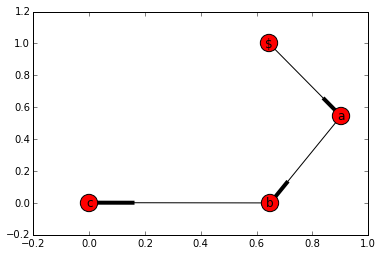

In [29]:
nx.draw_networkx(abc);

## Exercises

### Ex 0: Sample from an FSA

Write a function `sample` that takes an FSA as input and returns a string in the language of that FSA.

### Ex 1: Recognize any number

Write an FSA to recognize any number (unbounded number of digits)


### Ex 2: Any number between 1 and 31 (both inclusive)

Write an FSA to recognize all the numbers between 1 and 31.


### Ex 3: Uppercase the beginning of all words

Rewrite input strings of your choosing using the `transduce` function such that each word in the output string starts  with a capital letter. 

### Ex 4: (Ponder) Move letters to the end of the word

If a word starts with an *a* or a *b*, move it to the end of the word.